<a href="https://colab.research.google.com/github/brandon-birchall/SnareGAN/blob/main/SnareGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Snare Sounds
A journey into the usage of a DCGAN to create snare sounds. A for fun project.

## Design

My initial thoughts are to take an arbitrary but small dimensional vector of noise and to scale it using a generator to a tensor which represents many fourier series which when converted back to the time domain and played in sequence, should represent a snare sound (if the generator is trained enough)

The discriminator should determine whether the input fourier series' is from a real snare or a generated snare. This will determine the loss of both the generator and the discriminator. As such, this is a form of zero sum game. 

In terms of specifics, I will follow a conventional GCGAN architecture: a fully connected layer followed by transposing convolutions to the desired output size in the generator. And effectively the reverse for the discriminator. All using (primarily) LeakyReLU activation and Batch Normalization (With exception of tanh for the output of the generator) This is tried and tested, however I will experiment with variations as I go along.

Additionally, I will be making use of tensorboard to view losses and other network metrics. This will aid my design decisions.

# Imports

In [276]:
!pip install tensorflow_io

In [277]:
#Misc
from datetime import datetime
from IPython import display
import os
import time

#ML
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import librosa 

#Visualization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard



# Loading the datasets
This system uses the *Drum Sound Effects dataset* from ***Donahue, C., J. McAuley, and M. Puckette. 2019. "Adversarial Audio Synthesis."***

In [280]:
BUFFER_SIZE = 60000
BATCH_SIZE = 131

In [281]:
drum_sounds_file = tf.keras.utils.get_file(
    "drum_sounds",
    "http://deepyeti.ucsd.edu/cdonahue/wavegan/data/drums.tar.gz",
    cache_dir='./',
    extract=True)

In [282]:
#(Taken from https://www.tensorflow.org/tutorials/audio/transfer_learning_audio)

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [283]:
def load_dataset():
  i = 0
  filenames = []

  for subdir, dirs, files in os.walk("datasets/drums/train"): 
      for file in files:
          if "Snare" in file:
            filenames.append("datasets/drums/train/" + file)
          
  print("Loaded " + str(len(filenames)) + " samples")

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.map(load_wav_16k_mono)

  return dataset
  


## Processing the dataset
We need to move our wav files into the frequency domain using STFTs




To do this, we create a function which converts a signal to it's composing STFT slices, as shown below:

In [284]:
length = 16384

def waveform_to_stft(waveform):
  #Pad with zeroes for short waveforms 
  zero_padding = tf.zeros([length] - tf.shape(waveform), dtype=tf.float32)

  #Truncate longer waveforms
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  slices = tf.signal.stft(equal_length, 256, 128)

  slices = tf.reshape(slices, shape=[16383,])
  slices = tf.pad(slices, [[0,1]])

  slices = tf.reshape(slices, shape=[128,128, 1])

  return abs(slices)

In [285]:
dataset = load_dataset()
ds_iter = iter(dataset)

#Print first 3 elements of dataset
for i in range(3):
  print(next(ds_iter))

#Convert waveforms to Frequency domain
dataset = dataset.map(waveform_to_stft)

dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)



#print(dataset)
#print(dataset.element_spec)
#print(next(iter(dataset)))

Loaded 786 samples
tf.Tensor(
[ 1.5343568e-07 -7.7571372e-09  1.5673277e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(16384,), dtype=float32)
tf.Tensor(
[ 3.7961648e-08 -9.3715329e-08  1.7686332e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(16384,), dtype=float32)
tf.Tensor(
[-1.5767326e-07 -7.5542397e-07  1.1445964e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(16384,), dtype=float32)


<PrefetchDataset shapes: (None, 128, 128, 1), types: tf.float32>

# Creating the models

## The Generator
The generator takes a tensor of normally distributed noise and outputs a 128x128x1 tensor representing 128 fourier series' each with 128 terms. It does this using 6 convolution layers.

In [286]:
input_shape = [100,]

def create_generator():
  model = tf.keras.Sequential()

  #Input layer
  model.add(tf.keras.layers.InputLayer(input_shape))

  #Fully connected-layer
  model.add(tf.keras.layers.Dense(units=512 * 64, use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  #Reshape
  model.add(tf.keras.layers.Reshape(target_shape=[4,4,2048]))

  #Transposed convolution to 1024 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(1024, 5, 1, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape(target_shape=[4,4,1024]))

  #Transposed convolution to 512 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(512, 5, 2, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape(target_shape=[8,8,512]))

  #Transposed convolution to 256 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(256, 5, 2, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape(target_shape=[16,16,256]))

  #Transposed convolution to 64 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(64, 5, 2, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape(target_shape=[32,32,64]))

  #Transposed convolution to 32 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(32, 5, 2, padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape(target_shape=[64,64,32]))

  #Final transposed convolution to 1 dimensional space
  model.add(tf.keras.layers.Conv2DTranspose(1, 5, 2, padding='same', use_bias=False))
  model.add(tf.keras.layers.Activation('tanh'))

  model.add(tf.keras.layers.Reshape(target_shape=[128,128,1]))
  assert model.output_shape == (None, 128, 128, 1)

  return model

### Testing the generator

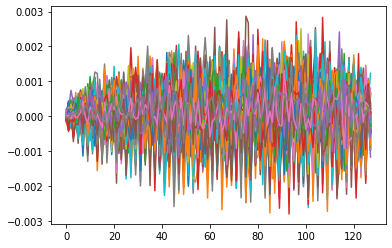

In [287]:
#Create the generator
generator = create_generator()
plot_model(generator, show_shapes=True)

#Create noise
noise = tf.random.normal([1, 100])
generated_sound = generator(noise, training=False)

#Outputs as expected (Noise for now as network is untrained)
plt.plot(generated_sound[0,:,:,0])
plt.show()

### Issues with STFT Representation
Currently the network outputs a STFT Tensor. This is where small slices of the sound are taken and transformed to frequency domain, as opposed to the signal as a whole. This offers a representation of how the sound changes with time and allows a smaller, lower-quality representation. It is what is usually used to create a spectrogram, which is what you typically associate with music in the frequency domain and allows more useful insight into music than a fourier transform applied to the entire waveform.

The problem with STFT is that it is not possible to directly convert a magnitude only spectrogram back to it's original signal without use of an algorithm. As such, I will make use of the *Griffin-Lim Algorithm*. My system will use *Librosa*'s implementation 

tf.Tensor(
[[1.5520558e-02 6.2397059e-02 9.8028421e-02 ... 1.6144039e-03
  1.3638499e-04 1.1882931e-04]
 [3.7254281e-03 2.4910597e-02 4.9185865e-02 ... 1.4842155e-03
  4.2710392e-04 6.0841441e-05]
 [6.5496400e-02 9.7330190e-02 1.7253862e-01 ... 1.2087067e-02
  5.7500233e-03 4.0951818e-03]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]], shape=(128, 65), dtype=float32)


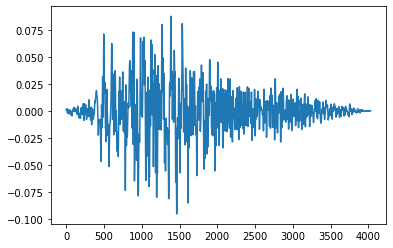

In [288]:
#Griffin-Lim reconstruction (https://librosa.org/doc/latest/generated/librosa.griffinlim.html)
sound = load_wav_16k_mono("datasets/drums/train/Snare_00623.wav")

stft = tf.signal.stft(sound, 128, 128)
stft = abs(stft)
reconstructed_sound = librosa.griffinlim(np.array(stft), n_iter=3)
print(stft)

plt.plot(reconstructed_sound)
plt.show()

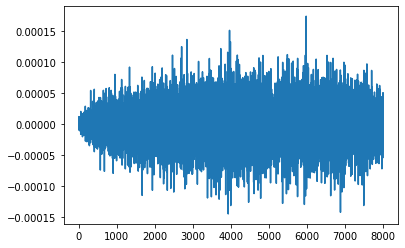

In [289]:
reconstructed_sound = librosa.griffinlim(np.array(generated_sound[0,:,:,0]), n_iter=3)

plt.plot(reconstructed_sound)
plt.show()

## The discriminator
The discriminator takes a 128x128x1 Tensor and outputs a Tensor which encodes how confident the discriminator is that the input belongs to the dataset. This is our adversary. The discriminator and generator will 'compete', the generator trying to fool the discriminator and the discriminator trying to catch out the generator. As such, over time, both should get very good at their jobs.

We will track their losses using TensorBoard and should see that they diverge, hopefully in the generator's favour

In [290]:
def create_discriminator():
  model = tf.keras.Sequential();

  #Input layer
  model.add(tf.keras.layers.InputLayer([128,128,1]))
  assert model.output_shape == (None, 128, 128, 1)

  #Convolution to 64 dimensional space
  model.add(tf.keras.layers.Conv2D(64, 5, 2, padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  #Convolution to 128 dimensional space
  model.add(tf.keras.layers.Conv2D(128, 5, 2, padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  #Final dense layer to determine output
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

### Testing the discriminator

tf.Tensor([[0.00011154]], shape=(1, 1), dtype=float32)


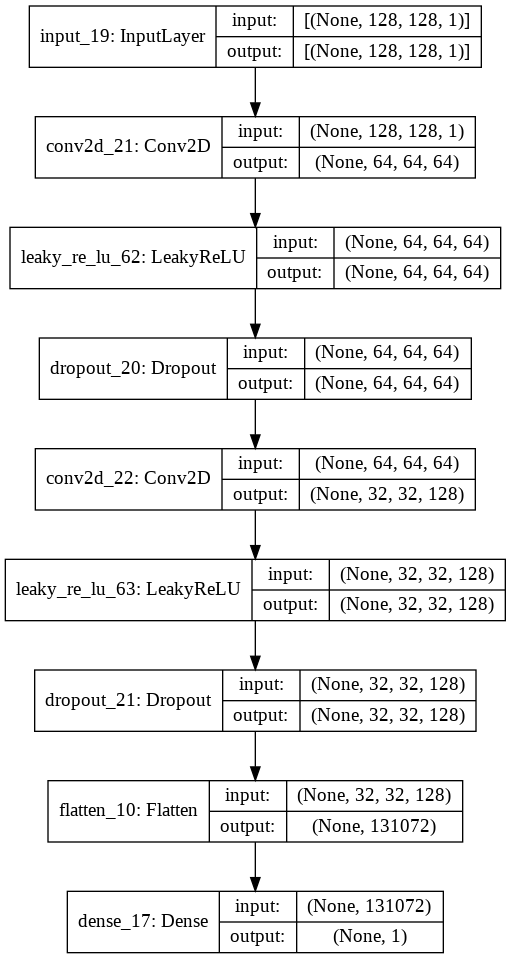

In [291]:
#Create the discriminator
discriminator = create_discriminator()

decision = discriminator(generated_sound)
print(decision)
plot_model(discriminator, show_shapes=True)


# Defining loss functions
(https://www.tensorflow.org/tutorials/generative/dcgan#define_the_loss_and_optimizers)


A GAN is 'adversarial' by nature, in that the loss of the generator will be higher when the loss of the discriminator is lower. 

In [292]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Discriminator loss
The discriminator loss function will compare the discriminator's predictions for real and fake images against the true value. The discriminator does well if it accuratly predicts which images are 'real' (from the dataset) and which are 'fake' (from the generator)

In [293]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss
The generator loss function compares the discriminator's predictions for fake images against the actual fake images. If the discriminator fails to categorize fake images as fake, the generator's loss function will be lower (The generator did a good job)

In [294]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# One last test...

Now let's test the system as a whole, obviously it won't be very good as we haven't trained it yet but let's make sure our networks are designed correctly and can process the data properly.

In [295]:
noise = tf.random.normal([1, 100])

generated_sample = generator(noise, training=False)
real_output = discriminator(generated_sample, training=False)

print(real_output)

tf.Tensor([[4.414177e-05]], shape=(1, 1), dtype=float32)


# Creating the training loop

In [296]:
EPOCHS = 10

In [297]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [306]:
#(Taken from https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [309]:
def train(dataset):
  for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for batch in dataset:
      #print(image_batch)
      batch = tf.reshape(batch, [1,128,128,1])
      train_step(batch)
    
      n+=1

    display.clear_output(wait=True)
    draw_sound(generator,epoch + 1,seed)

    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [310]:
def draw_sound(model, epoch, test_input):
  # Inference Mode (training=False)
  prediction = model(test_input, training=False)

  #Convert to time domain
  reconstructed_sound = librosa.griffinlim(np.array(prediction[0,:,:,0]), n_iter=3)

  plt.plot(reconstructed_sound)
  plt.show()


## Time to train!

In [ ]:
train(dataset)